# Twitter Sentiment Analysis: Practice Problem

## Problem Statement

Understanding the problem statement is the first and foremost step. This would help you give an intuition of what you will face ahead of time. Let us see the problem statement -

__*The objective of this task is to detect hate speech in tweets. For the sake of simplicity, we say a tweet contains hate speech if it has a racist or sexist sentiment associated with it. So, the task is to classify racist or sexist tweets from other tweets.*__

Formally, given a training sample of tweets and labels, where label '1' denotes the tweet is racist/sexist and label '0' denotes the tweet is not racist/sexist, your objective is to predict the labels on the test dataset.

*You can access the problem statement and the data over [here](https://datahack.analyticsvidhya.com/contest/practice-problem-twitter-sentiment-analysis/).*

## Loading Libraries and Data

In [2]:
import re # for regular expressions
import pandas as pd 
pd.set_option("display.max_colwidth", 200)
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk # for text manipulation
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn import svm
from gensim.models import KeyedVectors
from sklearn.ensemble import RandomForestClassifier
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Let's read train and test datasets.

In [3]:
train  = pd.read_csv('train.csv', sep=',', header=0)


### Adiciona coluna label com a classificacao mapeada pra rotulos numeros
* 0 = negativo
* 1 = positivo
* 2 = neutro

In [4]:
def label_classificacao(row):
    if row['Classificacao'] == 'Positivo' :
        return 1
    if row['Classificacao'] == 'Negativo' :
        return 0   
    return 2


In [5]:
train['rotulo'] = train.apply(lambda row: label_classificacao(row), axis=1)

In [6]:
test = pd.read_csv('test.csv', sep=',', header=0)

In [7]:
train.head(1)

,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,Observação,Id,rotulo
0,Mon Jan 09 15:27:43 +0000 2017,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg,NaN,NaN,NaN,Michele #beta #sdv,michelexmbeta,0,Positivo,NaN,6272,1


## Text PreProcessing and Cleaning

### Data Inspection

Let's check out a few non racist/sexist tweets.

In [8]:
train[train['rotulo'] == 0].head(1)

,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,Observação,Id,rotulo
5,Wed Jan 04 23:07:46 +0000 2017,"RT @Silvio_MKT: Fernando Pimentel PISA e COSPE em cima dos mineiros, é impressionante a cara de pau desse sujeito.https://t.co/MSqSlDMRAr",NaN,NaN,"São Paulo, SP",Israel Ziller,IsraelZiller,69,Negativo,NaN,4248,0


<br>
Tweets positivos

In [9]:
train[train['rotulo'] == 1].head(1)

,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Classificacao,Observação,Id,rotulo
0,Mon Jan 09 15:27:43 +0000 2017,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg,NaN,NaN,NaN,Michele #beta #sdv,michelexmbeta,0,Positivo,NaN,6272,1


Let's check dimensions of the train and test dataset.

In [10]:
train.shape, test.shape

((6559, 12), (1640, 10))

Train set has 6559 tweets and test set has 1640 tweets.

Let's have a glimpse at label-distribution in the train dataset.

In [11]:
train["rotulo"].value_counts()

1    2639
0    1970
2    1950
Name: rotulo, dtype: int64

<br>
Now we will check the distribution of length of the tweets, in terms of words, in both train and test data.

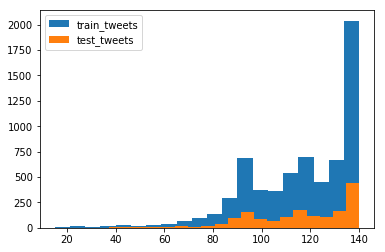

In [12]:
length_train = train['Text'].str.len()
length_test = test['Text'].str.len()

plt.hist(length_train, bins=20, label="train_tweets")
plt.hist(length_test, bins=20, label="test_tweets")
plt.legend()
plt.show()

The tweet-length distribution is more or less the same in both train and test data.


### Data Cleaning

In [13]:
combi = train.append(test, ignore_index=True)
combi.shape

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


(8199, 12)

Given below is a user-defined function to remove unwanted text patterns from the tweets.

In [14]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
#         print(input_txt)
        input_txt = re.sub(i, '', input_txt)
        
    return input_txt    

In [15]:
def remove_caracter(input_txt, caracter):
    return input_txt.replace(caracter,)    

__1. Removing Twitter Handles (@user)__

In [16]:
combi['TextLimpo'] = np.vectorize(remove_pattern)(combi['Text'], "@[\w]*") 
combi.head(5)

,Classificacao,Created At,Geo Coordinates.latitude,Geo Coordinates.longitude,Id,Observação,Retweet Count,Text,User Location,User Screen Name,Username,rotulo,TextLimpo
0,Positivo,Mon Jan 09 15:27:43 +0000 2017,NaN,NaN,6272,NaN,0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg,NaN,michelexmbeta,Michele #beta #sdv,1.0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg
1,Neutro,Sun Jan 08 02:14:34 +0000 2017,NaN,NaN,1644,NaN,0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semana...qué carajo les pasa ????,Núñez - C.A.B.A.,gabymessina36,Gaby Messina,2.0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semana...qué carajo les pasa ????
2,Positivo,Sat Feb 11 09:49:11 +0000 2017,NaN,NaN,7956,NaN,0,Líderes de motim em presídio de Minas Gerais serão transferidos https://t.co/3ycejsK0yB https://t.co/RrIeOwDV4z,"Hollywood, CA",Wendie_Rower,Wendie Rower,1.0,Líderes de motim em presídio de Minas Gerais serão transferidos https://t.co/3ycejsK0yB https://t.co/RrIeOwDV4z
3,Neutro,Thu Jan 05 14:43:03 +0000 2017,NaN,NaN,85,NaN,0,#Mídia: Press Release from Business Wire : Digital Living Network Alliance - Estado de Minas https://t.co/wj7wMchv8S,SP,binderbr,Marcello Binder,2.0,#Mídia: Press Release from Business Wire : Digital Living Network Alliance - Estado de Minas https://t.co/wj7wMchv8S
4,Positivo,Wed Feb 08 22:52:10 +0000 2017,NaN,NaN,6006,NaN,0,Vacinação contra febre amarela é intensificada na zona rural de Araxá https://t.co/kfaIzOt54Q https://t.co/VnrbOHzFbW,NaN,eufodeu,fodido,1.0,Vacinação contra febre amarela é intensificada na zona rural de Araxá https://t.co/kfaIzOt54Q https://t.co/VnrbOHzFbW


In [17]:
combi['TextLimpo'] = combi['TextLimpo'].str.replace("(", " ")
combi['TextLimpo'] = combi['TextLimpo'].str.replace(")", " ")
combi['TextLimpo'] = combi['TextLimpo'].str.replace("RT", " ")
combi.head(5)

,Classificacao,Created At,Geo Coordinates.latitude,Geo Coordinates.longitude,Id,Observação,Retweet Count,Text,User Location,User Screen Name,Username,rotulo,TextLimpo
0,Positivo,Mon Jan 09 15:27:43 +0000 2017,NaN,NaN,6272,NaN,0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg,NaN,michelexmbeta,Michele #beta #sdv,1.0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg
1,Neutro,Sun Jan 08 02:14:34 +0000 2017,NaN,NaN,1644,NaN,0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semana...qué carajo les pasa ????,Núñez - C.A.B.A.,gabymessina36,Gaby Messina,2.0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semana...qué carajo les pasa ????
2,Positivo,Sat Feb 11 09:49:11 +0000 2017,NaN,NaN,7956,NaN,0,Líderes de motim em presídio de Minas Gerais serão transferidos https://t.co/3ycejsK0yB https://t.co/RrIeOwDV4z,"Hollywood, CA",Wendie_Rower,Wendie Rower,1.0,Líderes de motim em presídio de Minas Gerais serão transferidos https://t.co/3ycejsK0yB https://t.co/RrIeOwDV4z
3,Neutro,Thu Jan 05 14:43:03 +0000 2017,NaN,NaN,85,NaN,0,#Mídia: Press Release from Business Wire : Digital Living Network Alliance - Estado de Minas https://t.co/wj7wMchv8S,SP,binderbr,Marcello Binder,2.0,#Mídia: Press Release from Business Wire : Digital Living Network Alliance - Estado de Minas https://t.co/wj7wMchv8S
4,Positivo,Wed Feb 08 22:52:10 +0000 2017,NaN,NaN,6006,NaN,0,Vacinação contra febre amarela é intensificada na zona rural de Araxá https://t.co/kfaIzOt54Q https://t.co/VnrbOHzFbW,NaN,eufodeu,fodido,1.0,Vacinação contra febre amarela é intensificada na zona rural de Araxá https://t.co/kfaIzOt54Q https://t.co/VnrbOHzFbW


__3. Removendo links__

In [18]:
combi['TextLimpo'] = np.vectorize(remove_pattern)(combi['TextLimpo'], r'http\S+') 
combi.head(5)

,Classificacao,Created At,Geo Coordinates.latitude,Geo Coordinates.longitude,Id,Observação,Retweet Count,Text,User Location,User Screen Name,Username,rotulo,TextLimpo
0,Positivo,Mon Jan 09 15:27:43 +0000 2017,NaN,NaN,6272,NaN,0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg,NaN,michelexmbeta,Michele #beta #sdv,1.0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG
1,Neutro,Sun Jan 08 02:14:34 +0000 2017,NaN,NaN,1644,NaN,0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semana...qué carajo les pasa ????,Núñez - C.A.B.A.,gabymessina36,Gaby Messina,2.0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semana...qué carajo les pasa ????
2,Positivo,Sat Feb 11 09:49:11 +0000 2017,NaN,NaN,7956,NaN,0,Líderes de motim em presídio de Minas Gerais serão transferidos https://t.co/3ycejsK0yB https://t.co/RrIeOwDV4z,"Hollywood, CA",Wendie_Rower,Wendie Rower,1.0,Líderes de motim em presídio de Minas Gerais serão transferidos
3,Neutro,Thu Jan 05 14:43:03 +0000 2017,NaN,NaN,85,NaN,0,#Mídia: Press Release from Business Wire : Digital Living Network Alliance - Estado de Minas https://t.co/wj7wMchv8S,SP,binderbr,Marcello Binder,2.0,#Mídia: Press Release from Business Wire : Digital Living Network Alliance - Estado de Minas
4,Positivo,Wed Feb 08 22:52:10 +0000 2017,NaN,NaN,6006,NaN,0,Vacinação contra febre amarela é intensificada na zona rural de Araxá https://t.co/kfaIzOt54Q https://t.co/VnrbOHzFbW,NaN,eufodeu,fodido,1.0,Vacinação contra febre amarela é intensificada na zona rural de Araxá


__2. Removing Punctuations, Numbers, and Special Characters__

In [19]:
def remover_str_expressao_regular(texto, padrao):
    texto = re.sub(padrao,'', texto)
    return texto

In [20]:
# combi['TextLimpo'] = combi['TextLimpo'].str.replace("[^a-zA-Z#]", " ")
combi['TextLimpo'] = np.vectorize(remover_str_expressao_regular)(combi['TextLimpo'], r'[^\w\s]') 
combi.head(5)

,Classificacao,Created At,Geo Coordinates.latitude,Geo Coordinates.longitude,Id,Observação,Retweet Count,Text,User Location,User Screen Name,Username,rotulo,TextLimpo
0,Positivo,Mon Jan 09 15:27:43 +0000 2017,NaN,NaN,6272,NaN,0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg,NaN,michelexmbeta,Michele #beta #sdv,1.0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG
1,Neutro,Sun Jan 08 02:14:34 +0000 2017,NaN,NaN,1644,NaN,0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semana...qué carajo les pasa ????,Núñez - C.A.B.A.,gabymessina36,Gaby Messina,2.0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semanaqué carajo les pasa
2,Positivo,Sat Feb 11 09:49:11 +0000 2017,NaN,NaN,7956,NaN,0,Líderes de motim em presídio de Minas Gerais serão transferidos https://t.co/3ycejsK0yB https://t.co/RrIeOwDV4z,"Hollywood, CA",Wendie_Rower,Wendie Rower,1.0,Líderes de motim em presídio de Minas Gerais serão transferidos
3,Neutro,Thu Jan 05 14:43:03 +0000 2017,NaN,NaN,85,NaN,0,#Mídia: Press Release from Business Wire : Digital Living Network Alliance - Estado de Minas https://t.co/wj7wMchv8S,SP,binderbr,Marcello Binder,2.0,Mídia Press Release from Business Wire Digital Living Network Alliance Estado de Minas
4,Positivo,Wed Feb 08 22:52:10 +0000 2017,NaN,NaN,6006,NaN,0,Vacinação contra febre amarela é intensificada na zona rural de Araxá https://t.co/kfaIzOt54Q https://t.co/VnrbOHzFbW,NaN,eufodeu,fodido,1.0,Vacinação contra febre amarela é intensificada na zona rural de Araxá


__4. Remover quebra de linha__

In [21]:
combi['TextLimpo'] = combi['TextLimpo'].str.replace("\n", " ")
combi['TextLimpo'] = combi['TextLimpo'].str.replace("\r", " ")

__5. Carregar lista de stop words__

In [22]:
with open('stopwords.txt') as f:
    content = f.readlines()
stop_words_list = [x.strip() for x in content] 

Let’s take another look at the first few rows of the combined dataframe.

In [23]:
combi.head(2)

,Classificacao,Created At,Geo Coordinates.latitude,Geo Coordinates.longitude,Id,Observação,Retweet Count,Text,User Location,User Screen Name,Username,rotulo,TextLimpo
0,Positivo,Mon Jan 09 15:27:43 +0000 2017,NaN,NaN,6272,NaN,0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG https://t.co/g258J0owsg,NaN,michelexmbeta,Michele #beta #sdv,1.0,Dois são detidos ao tentar jogar celulares e drogas em presídio de MG
1,Neutro,Sun Jan 08 02:14:34 +0000 2017,NaN,NaN,1644,NaN,0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semana...qué carajo les pasa ????,Núñez - C.A.B.A.,gabymessina36,Gaby Messina,2.0,me matan esas minas q cambian 554 veces su foto de whatsapp y 628 veces el estado en 1 semanaqué carajo les pasa


In [24]:
def tokenize(text):
    # Tokenização
    tokens = nltk.word_tokenize(text)
    tokens = [token.lower() for token in tokens]
    tokens = [token for token in tokens if token not in stop_words_list]
    return tokens
print(combi['TextLimpo'][0])
print(tokenize(combi['TextLimpo'][0]))

Dois são detidos ao tentar jogar celulares e drogas em presídio de MG  
['dois', 'detidos', 'tentar', 'jogar', 'celulares', 'drogas', 'presídio', 'mg']


In [25]:
texto_limpo_tokenizado = combi['TextLimpo'].apply(lambda x: tokenize(x)) # tokenizing

In [26]:
texto_limpo_tokenizado.head(1)

0    [dois, detidos, tentar, jogar, celulares, drogas, presídio, mg]
Name: TextLimpo, dtype: object

Now we can normalize the tokenized tweets.

In [27]:
for i in range(len(texto_limpo_tokenizado)):
    texto_limpo_tokenizado[i] = ' '.join(texto_limpo_tokenizado[i])
    
combi['TextLimpo'] = texto_limpo_tokenizado

In [28]:
texto_limpo_tokenizado.head(1)

0    dois detidos tentar jogar celulares drogas presídio mg
Name: TextLimpo, dtype: object

## Extracting Features from Cleaned Tweets

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim

### TF-IDF Features

In [30]:
# tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
# tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stop_words_list)
tfidf = tfidf_vectorizer.fit_transform(combi['TextLimpo'])
tfidf_3gram_vectorizer = TfidfVectorizer(ngram_range=(1,5), stop_words=stop_words_list)
tfidf_3gram = tfidf_3gram_vectorizer.fit_transform(combi['TextLimpo'])
print(tfidf.shape)
print(tfidf_3gram.shape)

(8199, 21001)
(8199, 66501)


---

## Model Building

We are now done with all the pre-modeling stages required to get the data in the proper form and shape. We will be building models on the datasets with different feature sets prepared in the earlier sections — Bag-of-Words, TF-IDF, word2vec vectors, and doc2vec vectors. We will use the following algorithms to build models:

1. Logistic Regression
2. Support Vector Machine
3. RandomForest
4. XGBoost

#### TF-IDF Features

In [31]:
train_tfidf_full = tfidf[:6559,:]
train_tfidf_3gram_full = tfidf_3gram[:6559,:]

# splitting data into training and validation set
xtrain_tfif, xvalid_tfidf, ytrain_tfidf, yvalid_tfidf = train_test_split(train_tfidf_full, train['rotulo'][:6559],  
                                                          random_state=42, 
                                                          test_size=0.3)


y_full = train['rotulo'][:6559]

xtrain_tfif_3gram, xvalid_tfidf_3gram, ytrain_tfidf_3gram, yvalid_tfidf_3gram = train_test_split(train_tfidf_full, train['rotulo'][:6559],  
                                                          random_state=42, 
                                                          test_size=0.3)




Public Leaderboard F1 Score: 0.564

#### TF-IDF bigram Features

In [32]:
svc_tfidf_bigram = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_tfif, ytrain_tfidf)
prediction = svc_tfidf_bigram.predict(xvalid_tfidf)
f1_score_result = f1_score(yvalid_tfidf, prediction, average='macro') # calculating f1 score
acc_result = accuracy_score(yvalid_tfidf, prediction) # calculating accuracy
print('f1_score: %s | acc: %s' % (f1_score_result, acc_result))

f1_score: 0.9591619950286233 | acc: 0.9613821138211383


## TF-IDF 3-gram

In [33]:
svc_tfidf_3gram = svm.SVC(kernel='linear', C=1.2, probability=True).fit(xtrain_tfif_3gram, ytrain_tfidf_3gram)
prediction_tfidf_3gram = svc_tfidf_3gram.predict(xvalid_tfidf_3gram)
f1_score_result_tfid_3gram = f1_score(yvalid_tfidf_3gram, prediction_tfidf_3gram, average='macro') # calculating f1 score
acc_result_3gram = accuracy_score(yvalid_tfidf_3gram, prediction_tfidf_3gram) # calculating accuracy
print('f1_score: %s | acc: %s' % (f1_score_result_tfid_3gram, acc_result_3gram))

f1_score: 0.9591716670032219 | acc: 0.9613821138211383


### Melhor resultado com SVM usando TFIDF sem normalizacao lexical. treinar o SVM e trainset completo.

In [34]:
train_tfidf = tfidf[:6559,:]
y_train_full = train['rotulo'][:6559]
svc = svm.SVC(kernel='linear', C=1, probability=True).fit(train_tfidf, y_train_full)


In [35]:
test.head(2)

,Created At,Text,Geo Coordinates.latitude,Geo Coordinates.longitude,User Location,Username,User Screen Name,Retweet Count,Observação,Id
0,Thu Jan 05 12:00:34 +0000 2017,RT @JDanieldf: Pedindo para que MG reaja? Reagir contra o governador queridinho dos eleitores mineiros? https://t.co/mMCw5wyyL8,NaN,NaN,Balneário Camboriú - SC,Mirela Franz,MiLick74,27,NaN,3568
1,Fri Jan 06 11:54:50 +0000 2017,Homem que matou ex-mulher e jogou corpo em cisterna contou com ajuda de amigo - Gerais - Estado de Minas https://t.co/BoRuUPDEBG,NaN,NaN,Belo Horizonte MG Brasil,Ricardo Carlini,carlinibh,1,NaN,1323


## treinamento de word2vec com SVM

In [36]:
tokenized_tweet = combi['TextLimpo'].apply(lambda x: x.split()) # tokenizing
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            size=200, # desired no. of features/independent variables 
            window=3, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(combi['TextLimpo']), epochs=20)

(1114419, 1547860)

In [37]:
def word_vector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += model_w2v[word].reshape((1, size))
            count += 1.
        except KeyError: # handling the case where the token is not in vocabulary
                         
            continue
    if count != 0:
        vec /= count
    return vec

#### Word2Vec Features

In [38]:
wordvec_arrays = np.zeros((len(tokenized_tweet), 200))

for i in range(len(tokenized_tweet)):
    wordvec_arrays[i,:] = word_vector(tokenized_tweet[i], 200)
    
wordvec_df = pd.DataFrame(wordvec_arrays)
wordvec_df.shape    

(8199, 200)

In [39]:
print(train.shape)
train_w2v = wordvec_df.iloc[:6559,:]
# test_w2v = wordvec_df.iloc[6000:6559,:]

xtrain_w2c, xvalid_w2c, ytrain, yvalid = train_test_split(train_w2v, train['rotulo'][:6559],  
                                                          random_state=42, 
                                                          test_size=0.3)

xtrain_w2v = train_w2v.iloc[ytrain.index,:]
xvalid_w2v = train_w2v.iloc[yvalid.index,:]

(6559, 12)


In [40]:
svc_w2v = svm.SVC(kernel='linear', C=1, probability=True).fit(xtrain_w2v, ytrain)

prediction = svc_w2v.predict(xvalid_w2v)
f1_score_result = f1_score(yvalid, prediction, average='macro') # calculating f1 score
acc_result = accuracy_score(yvalid, prediction) # calculating accuracy
print('f1_score: %s | acc: %s' % (f1_score_result, acc_result))

f1_score: 0.9322588162676593 | acc: 0.9344512195121951


### 3. RandomForest

In [41]:
rf_3gram = RandomForestClassifier(n_estimators=200, random_state=11).fit(xtrain_tfif_3gram, ytrain_tfidf_3gram)

In [43]:
prediction_rf_3gram = rf_3gram.predict(xvalid_tfidf_3gram)
f1_score_result_rf_3gram = f1_score(yvalid_tfidf_3gram, prediction_rf_3gram, average='macro')
acc_result_rf_3gram = accuracy_score(yvalid_tfidf_3gram, prediction_rf_3gram) # calculating accuracy
print('f1_score: %s | acc: %s' % (f1_score_result_rf_3gram, acc_result_rf_3gram))

f1_score: 0.9565863539911815 | acc: 0.9583333333333334


##  treinamento de glove com SVM
#### modelo nao utilizado, uma vez que apresentou queda no desempenho acuracia de 94%, abixo dos outros modelos, e ao ser utilizado no ensemble aparentemente deteriorou o resultado final


## treinamento dos 3 classificadores com todo o dataset

In [45]:
svc_tfidf_bigram_full = svm.SVC(kernel='linear', C=1, probability=True).fit(train_tfidf_full, y_full)


In [46]:
svc_w2v_full = svm.SVC(kernel='linear', C=1, probability=True).fit(train_w2v, y_full)

In [47]:
rf_3gram_full = RandomForestClassifier(n_estimators=200, random_state=11).fit(train_tfidf_3gram_full, y_full)


In [48]:
test_tfidf = tfidf[6559:,:]
print(test_tfidf.shape)

(1640, 21001)


In [49]:
test_w2v = wordvec_df.iloc[6559:,:]
print(test_w2v.shape)

(1640, 200)


In [51]:
test_tfidf_3gram = tfidf_3gram[6559:,:]
print(test_tfidf_3gram.shape)

(1640, 66501)


In [52]:
estimator_list_full = [svc_tfidf_bigram_full, svc_w2v_full, rf_3gram_full]
x_test_list = [test_tfidf,test_w2v, test_tfidf_3gram]

In [53]:
def predict_from_multiple_estimator_index(estimators, X_list, weights = None):
    # Predict 'soft' voting with probabilities
    pred1 = np.asarray([clf.predict_proba(X) for clf, X in zip(estimators, X_list)])
    pred2 = np.average(pred1, axis=0, weights=weights)
    pred = np.argmax(pred2, axis=1)
    # Convert integer predictions to original labels:
    return pred

In [54]:
y_test_pred_indexed =  predict_from_multiple_estimator_index(estimator_list_full, x_test_list)

In [55]:
y_test_pred = []
list_classes = svc_tfidf_bigram_full.classes_
for y_index in y_test_pred_indexed:
    y_preditec = list_classes[y_index]
    y_test_pred.append(y_preditec)
y_test_pred = np.array(y_test_pred)

In [56]:
print(y_test_pred_indexed)
print(y_test_pred)

[0 2 1 ... 2 2 0]
[0 2 1 ... 2 2 0]


In [57]:
print(svc_tfidf_bigram_full.classes_)
print(svc_w2v_full.classes_)
print(rf_3gram_full.classes_)

[0 1 2]
[0 1 2]
[0 1 2]


In [58]:
def classificacao_to_label(label):
    if label == 1 :
        return 'Positivo'
    if label == 0 :
        return 'Negativo'   
    return 'Neutro'


In [82]:
test['Category'] =   np.vectorize(classificacao_to_label)(y_test_pred)
submission = test[['Id','Category']]
submission.to_csv('sub_svc_rf_ensemble.csv', index=False)